(891, 12)
(891, 9) (418, 8)
(1309, 10)
       PassengerId    Survived       Pclass          Age        SibSp        Parch         Fare
count  1309.000000  891.000000  1309.000000  1309.000000  1309.000000  1309.000000  1309.000000
mean    655.000000    0.383838     2.294882    29.503186     0.498854     0.385027    33.281086
std     378.020061    0.486592     0.837836    12.905241     1.041658     0.865560    51.741500
min       1.000000    0.000000     1.000000     0.170000     0.000000     0.000000     0.000000
25%     328.000000    0.000000     2.000000    22.000000     0.000000     0.000000     7.895800
50%     655.000000    0.000000     3.000000    28.000000     0.000000     0.000000    14.454200
75%     982.000000    1.000000     3.000000    35.000000     1.000000     0.000000    31.275000
max    1309.000000    1.000000     3.000000    80.000000     8.000000     9.000000   512.329200


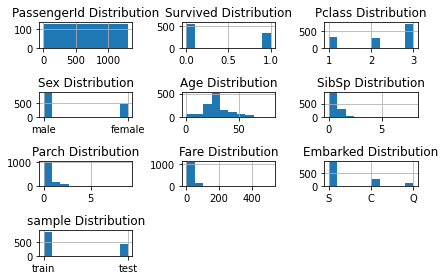

             Unique Values
Variable                  
PassengerId           1309
Pclass                   3
Sex                      2
Age                     98
SibSp                    4
Parch                    4
Fare                   281
Embarked                 4
sample                   2
Binary variables are  ['Sex', 'sample']
Categorical variables are  ['Pclass', 'SibSp', 'Parch', 'Embarked']
Numeric variables are  ['Fare', 'PassengerId', 'Age']
(1309, 16)
   PassengerId  Survived  Sex   Age      Fare sample  Pclass_2  Pclass_3  SibSp_1  SibSp_2  SibSp_3  Parch_1  Parch_2  Parch_3  Embarked_Q  Embarked_S
0            1       0.0    1  22.0  2.110213  train         0         1        1        0        0        0        0        0           0           1
1            2       1.0    0  38.0  4.280593  train         0         0        1        0        0        0        0        0           0           0
2            3       1.0    0  26.0  2.188856  train         0         1     

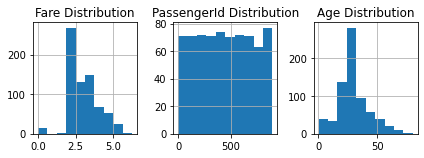

logistic  0.8230337078651686 {'C': 1.0, 'penalty': 'l2'}
knn  0.797752808988764 {'n_neighbors': 9}
svm  0.8188202247191011 {'C': 0.7000000000000001}
rf  0.8286516853932584 {'max_depth': 6, 'max_features': 0.5000000000000001, 'n_estimators': 200}
4 models time  76.74239015579224
Fitting 8 folds for each of 30 candidates, totalling 240 fits
bt  0.8638910109498344 {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
bt time  49.92750382423401
[20:42:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Epoch 1/300
23/23 [==============================] - 1s 11ms/step - loss: 0.7784 - accuracy: 0.5534 - val_loss: 0.6478 - val_accuracy: 0.6313
Epoch 2/300
23/23 [==============================] - 0s 5ms/step - loss: 0.6876 - accuracy: 0.6348 - val_loss: 0.6328 - val_accuracy: 0.6648
Epoch 3/300
2

In [76]:
##################################################################################################
### This script is ML Classification template, which should be applicable to most MLC projects ###
##################################################################################################

# In v_14 I merge all cells into a single one.

"""Structure of the script:
1. Load all needed libraries and functions.
2. Load data, do preliminary data exploration, deal with missing values.
3. [Optional] Transform skewed variables.
4. Trnasform features depending on their type. OHC.
5. Create subsamples.
6. Do scaling.
7. Fit models, selecting hyperparameters via CV grid search.
8. Evaluate performance of the selected models on test sample.
"""
# it is not the latest ML template. See HackerRank_ML_availability_final for later version.

### 1.Load main libraries ###

import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn import svm
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier

pd.set_option('display.max_columns', 20)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.expand_frame_repr', False)

def draw_histograms(df, variables, n_rows, n_cols):
    # stolen from https://stackoverflow.com/questions/29530355/plotting-multiple-histograms-in-grid
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  
    plt.show()

### 2.Load data ###

time1 = time.time()

path = '../input/titanic/train.csv'
df = pd.read_csv(path) # titanic_fullsample
print(df.shape)
df.drop(columns=['Name', 'Ticket', 'Cabin'],inplace=True)
df.head()

test_data=pd.read_csv('../input/titanic/test.csv')
test_data.drop(columns=['Name', 'Ticket', 'Cabin'],inplace=True)
test_data.head()

print(df.shape, test_data.shape)
train = df.copy()
test = test_data.copy()
train['sample']='train'
test['Survived'] = np.nan
test['sample']='test'

df=pd.concat([train, test])
df.reset_index(inplace=True, drop=True)
print(df.shape)
df.tail(3)

# deal with mising values

df.loc[df.Age.isnull(),'Age'] = df.Age.median()
df.loc[df.Fare.isnull(),'Fare'] = df.Fare.median()
print(df.describe())
# sns.pairplot(df[['Survived', 'Pclass', 'Age', 'Fare']])
draw_histograms(df, df.columns, 4, 3)

#%% 3.Transform some skewed variables ###

df['Fare'] = np.log1p(df.Fare)

#%% 4.Transform features depending on their type ###

# this is very important for ML application, where there are hundreds of features.
# If there are less than 20 features, can use standard approach.
# my approach of tackling one feature a time is not scalable. 

# use intuition to trim range or ordinary variables 
# can skip this step in general, since it is not scalable when number of features grows.
df.loc[df.SibSp>2,'SibSp']=3
df.loc[df.Parch>2,'Parch']=3

# identify binary and categorical variables
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques.drop('Survived', inplace = True)
print(df_uniques)

binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
categorical_variables = list(df_uniques[(6 >= df_uniques['Unique Values']) & (df_uniques['Unique Values'] > 2)].index)
numeric_variables = list(set(df.columns) - set(categorical_variables) - set(binary_variables) - set(['Survived']))
print('Binary variables are ', binary_variables)
print('Categorical variables are ', categorical_variables)
print('Numeric variables are ', numeric_variables)

# ohc for binary variables #
lb = LabelBinarizer()
binary_variables.remove('sample')
for column in binary_variables:
    df[column] = lb.fit_transform(df[column])

# ohc for categorical variables #
df = pd.get_dummies(df, columns = categorical_variables, drop_first=True)

print(df.shape)
print(df.head())

# %% 5.Creating subsamples ###

train = df[df['sample']=='train'].copy()
train.drop(columns=['sample'], inplace=True)
test = df[df['sample']=='test'].copy()
test.drop(columns=['sample'], inplace=True)

print(train.shape)
print(test.shape)
train.head(3)

y_train = train['Survived']
X_train = train.drop(columns=['Survived'])
X_test = test.drop(columns=['Survived'])

print(X_train.shape)
X_train.head(3)

X_train, X_traintest, y_train, y_traintest = train_test_split(X_train,y_train,test_size=0.2, random_state=8)

print(X_train.shape)
print(X_traintest.shape)
print(X_test.shape)
X_traintest.head(3)

# 'traintest' is hold-out sample to veify that chosen model indeed works.
# it is different from 'test', which is truly out of sample.

# %% 6.scaling numeric variables ###

draw_histograms(X_train, numeric_variables, 2, 3)

ss = StandardScaler()

for column in [numeric_variables]:
    X_train[column] = ss.fit_transform(X_train[column])
    X_traintest[column] = ss.transform(X_traintest[column])
    X_test[column] = ss.transform(X_test[column])

####################
### 7.Fit models ###
####################

time1_1 = time.time()

#%% Logistic regression ###

grid_values = {'penalty': ['l2'], 'C': list(np.arange(1,10.5,0.5))}
lr = LogisticRegression()
model_lr = GridSearchCV(lr, param_grid=grid_values, cv = 8)
model_lr.fit(X_train, y_train)
print('logistic ', model_lr.best_score_, model_lr.best_params_)

# model_lr.predict(X_test)

#%% KNN ###

grid_values = dict(n_neighbors=np.arange(5,25))
knnm = KNeighborsClassifier()   
model_knn = GridSearchCV(knnm, param_grid=grid_values, cv = 8)
model_knn.fit(X_train, y_train)
print('knn ', model_knn.best_score_, model_knn.best_params_)

#%% SVM ###

grid_values = {'C': np.arange(0.1, 4, 0.2)} 
svmm = svm.SVC(kernel='rbf')
model_svm = GridSearchCV(svmm, param_grid=grid_values, cv = 8)
model_svm.fit(X_train, y_train)
print('svm ', model_svm.best_score_, model_svm.best_params_)

#%% RF ###

# may look here: https://www.geeksforgeeks.org/hyperparameter-tuning/

grid_values = [{'max_depth': list(range(3, 7, 1)), 'max_features': list(np.arange(0.2,0.51,0.1)),
               'n_estimators': [100, 200]}]
rfc = RandomForestClassifier(random_state=42)
model_rf = GridSearchCV(rfc, grid_values, cv = 8, scoring='accuracy')
model_rf.fit(X_train, y_train)
print('rf ', model_rf.best_score_, model_rf.best_params_)
print('4 models time ', time.time()-time1_1)

#%% XGBoost ###
# run this code only on Kaggle with GPU

time2 = time.time()

estimator = XGBClassifier(
    nthread=4,
    seed=42,
    use_label_encoder=False
)

parameters = {
    'max_depth': range (2, 4, 1),
    'n_estimators': range(100, 301, 50),
    'learning_rate': [0.01, 0.03, 0.05]
}
t2 = time.time()
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 8,
    verbose=True
)

grid_search.fit(X_train, y_train, eval_metric='rmse')
print('bt ', grid_search.best_score_, grid_search.best_params_)
print('bt time ', time.time()-t2)

xgbc = XGBClassifier(nthread=4, seed=42, use_label_encoder=False,
                     max_depth=2, n_estimators=300, learning_rate=0.01)
xgbc.fit(X_train, y_train)

# here I will add ANN

from keras.models  import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

model_2 = Sequential()
model_2.add(Dense(50, input_shape=(X_train.shape[1],), activation="relu"))
model_2.add(Dropout(0.4))
model_2.add(BatchNormalization())
model_2.add(Dense(10, activation="relu"))
model_2.add(Dropout(0.4))
model_2.add(BatchNormalization())
model_2.add(Dense(1, activation="sigmoid"))

es = EarlyStopping(monitor='val_loss', patience=20)

model_2.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train, y_train, validation_data=(X_traintest, y_traintest), epochs=300, callbacks=[es])

# played a lot with ann. the best acc i can reliable achieve is 78.5%.
# but the second time (test set) I get 83%...
# usually its is competition btw rf and bt at the end. 

#%% 8.Evaluate performance oos ###

yhat_lm = model_lr.predict(X_traintest)
yhat_knn = model_knn.predict(X_traintest)
yhat_svm = model_svm.predict(X_traintest)
yhat_rf = model_rf.predict(X_traintest)
yhat_btcv = grid_search.predict(X_traintest)
yhat_btm = xgbc.predict(X_traintest)
print('Accuracy of logistic regression is ', 1-(np.abs(yhat_lm-y_traintest)).mean())
print('Accuracy of KNN is ', 1-(np.abs(yhat_knn-y_traintest)).mean())
print('Accuracy of SVM is ', 1-(np.abs(yhat_svm-y_traintest)).mean())
print('Accuracy of RF is ', 1-(np.abs(yhat_rf-y_traintest)).mean())
print('Accuracy of Boosted Tree cv is ', 1-(np.abs(yhat_btcv-y_traintest)).mean())
print('Accuracy of Boosted Tree manl is ', 1-(np.abs(yhat_btm-y_traintest)).mean())
print('total time is ', time.time() - time1)

In [78]:
### Export results ###
yhat_lr = model_lr.predict(X_test).astype(int)
yhat_rf = model_rf.predict(X_test).astype(int)
yhat_bt = grid_search.predict(X_test).astype(int)

submission_df_lr = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': yhat_lr}, columns=['PassengerId', 'Survived'])
submission_df_rf = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': yhat_rf}, columns=['PassengerId', 'Survived'])
submission_df_bt = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': yhat_bt}, columns=['PassengerId', 'Survived'])

submission_df_lr.to_csv('submissions_Titanic_i10_lr1.csv',index=False)
submission_df_rf.to_csv('submissions_Titanic_i10_rf1.csv',index=False)
submission_df_bt.to_csv('submissions_Titanic_i10_bt1.csv',index=False)

In [79]:
os.chdir(r'/kaggle/working')

from IPython.display import FileLink
FileLink(r'submissions_Titanic_i10_lr1.csv')

/kaggle/working/submissions_Titanic_i10_lr1.csv

In [80]:
FileLink(r'submissions_Titanic_i10_rf1.csv')

/kaggle/working/submissions_Titanic_i10_rf1.csv

In [81]:
FileLink(r'submissions_Titanic_i10_bt1.csv')

/kaggle/working/submissions_Titanic_i10_bt1.csv

In [69]:
yhat_lr.dtype

dtype('int64')